In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.common import *
from config.config import *

c:\Users\Admin\Data\AI_project\AI_final
c:/Users/Admin/Data/AI_project/AI_final


In [2]:
load_dotenv(find_dotenv())

True

In [3]:
# llm = ChatVertexAI(model="gemini-pro", api_key= os.getenv('GEMINI_API_KEY'))


### __1. LLM__

In [3]:
llm = ChatOpenAI(
    model_name="gpt-3.5-turbo",
    openai_api_key=os.getenv('OPEN_API_KEY'))



In [4]:
data_dir

'c:/Users/Admin/Data/AI_project/AI_final/data'

### __2. Rag with SQL__

In [10]:
file_paths=['events.xlsx', 'finance_ratio.xlsx','news.xlsx', 'profiles_vie.xlsx']
engine=create_engine(os.getenv('POSTGRESQL_DBMS_KEY'))
for file_path in file_paths:
    df=pd.read_excel(f'{data_dir}/{file_path}')
    table_name = os.path.splitext(os.path.basename(file_path))[0]    
    df.to_sql(table_name, engine, if_exists='replace', index=False)
    
    print(f"Đã đẩy dữ liệu từ {file_path} vào bảng {table_name} thành công!")


Đã đẩy dữ liệu từ events.xlsx vào bảng events thành công!
Đã đẩy dữ liệu từ finance_ratio.xlsx vào bảng finance_ratio thành công!
Đã đẩy dữ liệu từ news.xlsx vào bảng news thành công!
Đã đẩy dữ liệu từ profiles_vie.xlsx vào bảng profiles_vie thành công!


In [11]:
db = SQLDatabase.from_uri(os.getenv('POSTGRESQL_DBMS_KEY'))
db

In [12]:
print(db.dialect)
print(db.get_usable_table_names())

postgresql
['events', 'finance_ratio', 'news', 'profiles_vie']


In [25]:
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "Năm 2024 có những sự kiện gì nổi bật đối với công ty mã A32"})
print(response)

SELECT "event_name", "event_desc" 
FROM events 
WHERE ticker = 'A32' AND event_desc ILIKE '%2024%'
LIMIT 5;


In [26]:
db.run(response)

"[('A32 - Trả cổ tức Đợt 2 năm 2023 bằng tiền 2500 đồng/cổ phiếu', 'Công ty Cổ phần 32 (A32) trả cổ tức Đợt 2 năm 2023 bằng tiền:_x000D_ Ngày giao dịch không hưởng quyền: 16/08/2024_x000D_ Ngày đăng ký cuối cùng: 19/08/2024_x000D_ Thời gian thanh toán: 06/09/2024_x000D_ Tỷ lệ thực hiện: 25%/mệnh giá (2500 đồng/cổ phiếu). '), ('A32 - Tổ chức ĐHĐCĐ thường niên 2024', 'Công ty Cổ phần 32 (A32) tổ chức ĐHĐCĐ thường niên năm 2024:_x000D_ Ngày giao dịch không hưởng quyền: 29/03/2024_x000D_ Ngày đăng ký cuối cùng: 01/04/2024_x000D_ Thời gian thực hiện: 02/08/2024 08:00_x000D_ Địa điểm thực hiện: Công ty cổ phần 32- 170 Quang Trung, Phường 10, Quận Gò Vấp, Thành...'), ('A32 - Trả cổ tức Đợt 1 năm 2023 bằng tiền 1000 đồng/cổ phiếu', 'Công ty Cổ phần 32 (A32) trả cổ tức Đợt 1 năm 2023 bằng tiền:_x000D_ Ngày giao dịch không hưởng quyền: 21/12/2023_x000D_ Ngày đăng ký cuối cùng: 22/12/2023_x000D_ Thời gian thanh toán: 15/01/2024_x000D_ Tỷ lệ thực hiện: 10%/mệnh giá (1000 đồng/cổ phiếu). ')]"

In [27]:
chain.get_prompts()[0].pretty_print()


You are a PostgreSQL expert. Given an input question, first create a syntactically correct PostgreSQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per PostgreSQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use CURRENT_DATE function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLR

In [28]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

write_query = create_sql_query_chain(llm, db)
execute_query = QuerySQLDataBaseTool(db=db)

chain = write_query | execute_query

chain.invoke({"question": "Năm 2024 có những sự kiện gì nổi bật đối với công ty mã A32"})

"[('A32 - Trả cổ tức Đợt 2 năm 2023 bằng tiền 2500 đồng/cổ phiếu', 'Công ty Cổ phần 32 (A32) trả cổ tức Đợt 2 năm 2023 bằng tiền:_x000D_ Ngày giao dịch không hưởng quyền: 16/08/2024_x000D_ Ngày đăng ký cuối cùng: 19/08/2024_x000D_ Thời gian thanh toán: 06/09/2024_x000D_ Tỷ lệ thực hiện: 25%/mệnh giá (2500 đồng/cổ phiếu). '), ('A32 - Tổ chức ĐHĐCĐ thường niên 2024', 'Công ty Cổ phần 32 (A32) tổ chức ĐHĐCĐ thường niên năm 2024:_x000D_ Ngày giao dịch không hưởng quyền: 29/03/2024_x000D_ Ngày đăng ký cuối cùng: 01/04/2024_x000D_ Thời gian thực hiện: 02/08/2024 08:00_x000D_ Địa điểm thực hiện: Công ty cổ phần 32- 170 Quang Trung, Phường 10, Quận Gò Vấp, Thành...'), ('A32 - Trả cổ tức Đợt 1 năm 2023 bằng tiền 1000 đồng/cổ phiếu', 'Công ty Cổ phần 32 (A32) trả cổ tức Đợt 1 năm 2023 bằng tiền:_x000D_ Ngày giao dịch không hưởng quyền: 21/12/2023_x000D_ Ngày đăng ký cuối cùng: 22/12/2023_x000D_ Thời gian thanh toán: 15/01/2024_x000D_ Tỷ lệ thực hiện: 10%/mệnh giá (1000 đồng/cổ phiếu). ')]"

In [29]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)

answer = answer_prompt | llm | StrOutputParser()
chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer
)

chain.invoke({"question": "Năm 2024 có những sự kiện gì nổi bật đối với công ty mã A32"})

'Năm 2024, công ty mã A32 có các sự kiện nổi bật sau:\n1. Trả cổ tức Đợt 2 năm 2023 bằng tiền 2500 đồng/cổ phiếu. Ngày giao dịch không hưởng quyền: 16/08/2024. Ngày đăng ký cuối cùng: 19/08/2024. Thời gian thanh toán: 06/09/2024. Tỷ lệ thực hiện: 25%/mệnh giá (2500 đồng/cổ phiếu).\n2. Tổ chức ĐHĐCĐ thường niên 2024. Ngày giao dịch không hưởng quyền: 29/03/2024. Ngày đăng ký cuối cùng: 01/04/2024. Thời gian thực hiện: 02/08/2024 08:00. Địa điểm thực hiện: Công ty cổ phần 32- 170 Quang Trung, Phường 10, Quận Gò Vấp, Thành...\n3. Trả cổ tức Đợt 1 năm 2023 bằng tiền 1000 đồng/cổ phiếu. Ngày giao dịch không hưởng quyền: 21/12/2023. Ngày đăng ký cuối cùng: 22/12/2023. Thời gian thanh toán: 15/01/2024. Tỷ lệ thực hiện: 10%/mệnh giá (1000 đồng/cổ phiếu).'

### __3. Function calling__

In [5]:
###EUT
@tool
def calculate_utility(outcome: float, risk_aversion: float) -> float:
    """
    Tính toán độ hữu ích dựa trên kết quả và hệ số ngại rủi ro.

    Args:
        outcome: Kết quả tài chính cần đánh giá.
        risk_aversion: Hệ số ngại rủi ro.
    """
    if risk_aversion != 1:
        return (outcome ** (1 - risk_aversion)) / (1 - risk_aversion)
    else:
        return np.log(outcome)
@tool
def calculate_expected_utility(probabilities: List[float], utilities: List[float]) -> float:
    """
    Tính toán độ hữu ích kỳ vọng.

    Args:
        probabilities:Danh sách xác suất liên quan đến các kết quả khác nhau.
        utilities: Danh sách độ hữu ích tương ứng với các kết quả.

    Raises:
        ValueError:Nếu độ dài của probabilities và utilities không khớp nhau.
    """
    if len(probabilities) != len(utilities):
        raise ValueError("Probabilities and utilities must have the same length.")
    
    expected_utility = np.dot(probabilities, utilities)
    return expected_utility


# @tool
# def porfolio_optimize_EUT():
#     pass

###MVP
@tool
def calculate_portfolio_return(returns: List[float], weights: List[float]) -> float:
    """
    Tính toán lợi nhuận hàng năm của danh mục đầu tư.

    Args:
        returns: Danh sách lợi nhuận lịch sử của các tài sản trong danh mục đầu tư.
        weights: Danh sách tỷ trọng đại diện cho phần trăm của từng tài sản trong danh mục.
    """
    return np.dot(returns.mean(), weights) * 252

@tool
def calculate_portfolio_volatility(returns: List[float], weights: List[float]) -> float:
    """
    Tính toán biến động hàng năm của danh mục đầu tư.

    Args:
        returns:  Danh sách lợi nhuận lịch sử của các tài sản trong danh mục đầu tư.
        weights:  Danh sách tỷ trọng đại diện cho phần trăm của từng tài sản trong danh mục.
    """
    return np.dot(weights, np.dot(returns.cov() * 252, weights)) ** 0.5  # Annualized volatility

@tool
def calculate_sharpe_ratio(returns: List[float], weights: List[float], risk_free_rate: float) -> float:
    """
    Tính toán tỷ lệ Sharpe của danh mục đầu tư.

    Args:
        returns: Danh sách lợi nhuận lịch sử của các tài sản trong danh mục đầu tư.
        weights: Danh sách tỷ trọng đại diện cho phần trăm của từng tài sản trong danh mục.
        risk_free_rate: Tỷ lệ lợi nhuận không rủi ro.
    """
    port_return = calculate_portfolio_return(returns, weights)
    port_volatility = calculate_portfolio_volatility(returns, weights)
    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return sharpe_ratio

@tool
def portfolio_optimize(returns, sharpe_ratio_or_variance=True):
    """
    Tối ưu hóa danh mục đầu tư dựa trên tối ưu lợi nhuận hoặc giảm thiểu rủi ro sau khi biết được tình hình doanh mục đầu tư được dự đoán trong tương lai trước đó.

    Args:
        returns: Thông tin tình hình danh mục đầu tư sau khi dùng hàm predict_future_prices .
        sharpe_ratio_or_variance: Một giá trị boolean chỉ định có tối ưu hóa cho tỷ lệ Sharpe (True) hay biến động (False).
    """
    returns = json.loads(returns)
    returns = pd.DataFrame([returns])
    # returns=returns[returns.columns[1:]]
    # print(returns)
    num_assets = len(returns.columns)
    # print('haha',num_assets)
    init_guess = num_assets * [1. / num_assets]
    bounds = tuple((0, 1) for asset in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    if sharpe_ratio_or_variance:
        result = minimize(lambda x: -calculate_sharpe_ratio(x, returns), init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        result = minimize(lambda x: calculate_portfolio_volatility(x, returns), init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Chuyển đổi tỷ trọng tối ưu thành từ điển với tên cổ phiếu
    optimal_weights = dict(zip(returns.columns, result.x))
    
    return optimal_weights

### CAPM
@tool
def calculate_beta(asset_returns: List[float], market_returns: List[float]) -> float:
    """
    Tính toán hệ số beta của một tài sản.

    Args:
        asset_returns: Danh sách lợi nhuận của tài sản.
        market_returns: Danh sách lợi nhuận của thị trường.
    """
    covariance_matrix = np.cov(asset_returns, market_returns)
    beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
    return beta

@tool
def calculate_capm(risk_free_rate: float, beta: float, market_return: float) -> float:
    """
    Tính toán lợi nhuận kỳ vọng của một tài sản bằng công thức CAPM.

    Args:
        risk_free_rate: Tỷ lệ lợi nhuận không rủi ro.
        beta: Hệ số beta của tài sản.
        market_return: Lợi nhuận kỳ vọng của thị trường.
    """
    expected_return = risk_free_rate + beta * (market_return - risk_free_rate)
    return expected_return


#### Make prediction
@tool
def predict_future_prices(api_portfolio,symbols, n):
    """
    Dự đoán giá danh mục đầu tư trong n tháng tới dựa trên dữ liệu đầu vào. Phù hợp cho việc dự báo tình hình của danh mục 

    Args:
        api_portfolio: dữ liệu về một danh mục đầu tư gồm nhiều mã cổ phiếu khác nhau trong một khoảng thời gian
        symbols: Danh sách các mã cổ phiếu khác nhau thuộc danh mục đầu tư đó
        n: Số tháng từ ngày hiện tại để dự đoán.
    """
    data = api_portfolio

    try:
        df = pd.DataFrame(eval(data))
    except (ValueError, SyntaxError) as e:
        print(f"Error creating DataFrame: {e}")
        return
    
    if df.empty or not {'idx_time', 'AAA', 'A32'}.issubset(df.columns):
        print("Data không hợp lệ. Đảm bảo dữ liệu chứa các cột 'idx_time', 'AAA', và 'A32'.")
        return
    
    df['idx_time'] = pd.to_datetime(df['idx_time'] + '-01', format='%Y-%m-%d')
    
    df['days'] = (df['idx_time'] - df['idx_time'].min()).dt.days
    
    df = df.dropna(subset=symbols)
    
    degree = 2
    coeffs = {}

    for symbol in symbols:
        coeffs[symbol] = np.polyfit(df['days'], df[symbol], degree)
    
    future_dates = pd.date_range(start=pd.to_datetime('today').replace(day=1), periods=n, freq='MS')
    future_days = (future_dates - df['idx_time'].min()).days
    
    predictions = {}
    for symbol in symbols:
        predictions[symbol] = np.polyval(coeffs[symbol], future_days)
    
    future_df = pd.DataFrame({
        'idx_time': future_dates.strftime('%Y-%m'),  
        **predictions
    })
    
    last_prediction = future_df.iloc[-1]
    
    result = {symbol: last_prediction[symbol] for symbol in symbols}
    
    return json.dumps(result, default=str)

####Get API
@tool
def generate_prompt_with_date(prompt):
    """
    Tạo một prompt có kèm theo ngày hiện tại.

    Args:
        prompt: Chuỗi prompt ban đầu.
    """
    from datetime import datetime
    current_date = datetime.now().strftime("%Y-%m-%d")
    full_prompt = f"{prompt} Today's date is {current_date}."
    return full_prompt

@tool
def get_company_information(symbol):
    """
    Lấy thông tin công ty bao gồm tổng quan, hồ sơ, cổ đông, công ty con, và cán bộ. Phù hợp cho việc điều tra thông tin cụ thể của một doanh nghiệp trước khi đưa ra quyết định

    Args:
        symbol: Mã cổ phiếu của công ty.
    """
    company = Vnstock().stock(symbol=symbol, source='TCBS').company
    
    try:
        overview = company.overview()
        profile = company.profile()  # Assuming profile is another method; adjust if incorrect
        shareholders = company.shareholders()
        subsidiaries = company.subsidiaries()
        officers = company.officers()
        
        result = {
            "overview": overview,
            "profile": profile,
            "shareholders": shareholders,
            "subsidiaries": subsidiaries,
            "officers": officers
        }
    except Exception as e:
        result = {"error": str(e)}
    
    return json.dumps(result)


@tool
def get_api_stock(symbols, startday, endday):
    """
    Lấy dữ liệu cổ phiếu cho một mã và khoảng thời gian cụ thể.

    Args:
        symbols: Mã cổ phiếu cần lấy dữ liệu.
        startday: Ngày bắt đầu của khoảng thời gian.
        endday: Ngày kết thúc của khoảng thời gian.
    """


    stock = Vnstock().stock(symbol=symbols, source='TCBS')
    
    try:
        startday = pd.to_datetime(startday).strftime('%Y-%m-%d')
        endday = pd.to_datetime(endday).strftime('%Y-%m-%d')
        df = stock.quote.history(start=startday, end=endday, interval='1D')
        
        if not df.empty:
            df = df.map(lambda x: x.isoformat() if isinstance(x, (pd.Timestamp, pd.Timestamp)) else x)
            result = df.to_dict(orient='records')
        else:
            result = {"error": "Có lẽ ngày này ngân hàng không làm việc, do đây có thể là thứ bảy chủ nhật hoặc ngày lễ"}
        if startday==endday:
            result = [record for record in result if record['time'].startswith(startday)]
            if result.empty:
                result={"error": "Có lẽ ngày này ngân hàng không làm việc, do đây có thể là thứ bảy chủ nhật hoặc ngày lễ"}

    
    except Exception as e:
        result = {"error": "Có lẽ ngày này ngân hàng không làm việc, do đây có thể là thứ bảy chủ nhật hoặc ngày lễ"}

    
    return json.dumps(result, ensure_ascii=False)


@tool
def get_api_income_statement(symbols):
    """
    Truy xuất bảng báo cáo tài chính theo năm của từng doanh nghiệp cụ thể

    Args:
        symbols: Mã doanh nghiệp được niêm yết trên sàn chuwnsg khoán.
    """
    stock = Vnstock().stock(symbol=symbols, source='TCBS')
    try:
        df = stock.finance.income_statement(period='year', lang='en')
        if not df.empty:
            result = df.to_dict(orient='records')
        else:
            result = {"error": "No data found for the given range"}
    except Exception as e:
        result = {"error": str(e)}
    
    return json.dumps(result)

@tool
def get_api_portfolio(symbols):
    """
    Lấy dữ liệu về một danh mục đầu tư gồm nhiều mã cổ phiếu khác nhau trong một khoảng thời gian.

    Args:
        symbols: Một danh sách các mã cổ phiếu trong danh mục đầu tư.
    """
    endday = datetime.now()
    startday = endday - timedelta(days=365)
    
    data = pd.DataFrame()
    errors = []  # To store error messages for each symbol
    for symbol in symbols:
        stock = Vnstock().stock(symbol=symbol, source='TCBS')
        try:
            df = stock.quote.history(
                start=startday.strftime('%Y-%m-%d'), 
                end=endday.strftime('%Y-%m-%d'), 
                interval='1D'
            )
            if df.empty:
                errors.append(f"No data found for symbol {symbol}")
                continue
            
            df['time'] = pd.to_datetime(df['time'])
            df = df.sort_values(by='time', ascending=False)
            df['month'] = df['time'].dt.month
            df['year'] = df['time'].dt.year
            df['idx_time'] = df['time'].dt.to_period('M')
            
            df = df.drop_duplicates(subset=['idx_time'])
            df.set_index('idx_time', inplace=True)
            df = df[['close']]
            df.columns = [symbol]
            data = pd.concat([data, df], axis=1)
        except Exception as e:
            errors.append(f"Error for symbol {symbol}: {str(e)}")

    if data.empty:
        return json.dumps({"error": "No data found for the given symbols and range"}, default=str)
    
    data = data[~data.index.duplicated(keep='first')]
    data = data.groupby(data.index).mean()
    rets = np.log(data / data.shift(1)).dropna()
    
    result = rets.reset_index().to_dict(orient='records')

    # Convert the result and errors into a string for ToolMessage compatibility
    output = {"result": result, "errors": errors} if errors else result
    return json.dumps(output, default=str)

@tool
def get_api_balance_sheet(symbols):
    """
    Truy xuất bảng cân đối kế toán của từng doanh nghiệp cụ thể

    Args:
        symbols: Mã doanh nghiệp được định giá trên sàn chứng khoán
    """
    stock = Vnstock().stock(symbol=symbols, source='TCBS')
    try:
        df = stock.finance.balance_sheet(period='year', lang='en')
        if not df.empty:
            result = df.to_dict(orient='records')
        else:
            result = {"error": "No data found for the given range"}
    except Exception as e:
        result = {"error": str(e)}
    
    return json.dumps(result)


tools = [
    calculate_utility,
    calculate_expected_utility,
    calculate_portfolio_return,
    calculate_portfolio_volatility,
    calculate_sharpe_ratio,
    calculate_beta,
    calculate_capm,
    generate_prompt_with_date,
    get_company_information,
    get_api_stock,
    get_api_portfolio,
    get_api_income_statement,
    get_api_balance_sheet,
    predict_future_prices,
    portfolio_optimize,
]

llm_with_tools = llm.bind_tools(tools)


In [7]:
query = f"""Bạn là một chuyên gia chơi chứng khoán trong lĩnh vực kinh tế đầu tư tại thị trường chứng khoán Việt Nam. Hôm nay là ngày {datetime.now().strftime('%Y-%m-%d')} Sử dụng các tool được cung cấp như một ví dụ để đưa ra những lời khuyên hữu ích để người chơi mới tại Việt Nam lựa chọn và tối ưu hóa danh mục đầu tư, đầu tư chứng khoán thành công. Dự đoán một danh mục đầu tư của tôi bao gồm các mã cổ phiếu của sàn VNINDEX như là AAM, XPH, YEG, AAT trong 6 tháng tới và tối ưu hóa danh mục đầu tư để cho tôi biết tôi nên phân bổ vốn như thế nào.
"""
llm = ChatOpenAI(model="gpt-4-1106-preview" , api_key=os.getenv("OPEN_API_KEY"))


messages = [HumanMessage(query)]
ai_msg = llm_with_tools.invoke(messages)
print(f'Answer: {ai_msg}')
messages.append(ai_msg)

tool_mapping = {
    "calculate_utility": calculate_utility,
    "calculate_expected_utility": calculate_expected_utility,
    "calculate_portfolio_return": calculate_portfolio_return,
    "calculate_portfolio_volatility": calculate_portfolio_volatility,
    "calculate_sharpe_ratio": calculate_sharpe_ratio,
    "calculate_beta": calculate_beta,
    "calculate_capm": calculate_capm,
    "generate_prompt_with_date": generate_prompt_with_date,
    "get_company_information": get_company_information,
    "get_api_stock": get_api_stock,
    "get_api_income_statement": get_api_income_statement,
    "get_api_balance_sheet": get_api_balance_sheet,
    "predict_future_prices": predict_future_prices,
    "get_api_portfolio": get_api_portfolio,
    "portfolio_optimize": portfolio_optimize,
}


for tool_call in ai_msg.tool_calls:
    print(tool_call)
    selected_tool = tool_mapping[tool_call["name"].lower()]
    print(tool_call["args"])
    tool_output = selected_tool.invoke(dict(tool_call["args"]))
    print(type(tool_output), tool_output)
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

print(f'messages: {messages}')


Answer: content='' additional_kwargs={'tool_calls': [{'id': 'call_mfXAP94gkpiJZzA9DxTBgyku', 'function': {'arguments': '{"prompt":"Dự đoán giá của các cổ phiếu trong danh mục đầu tư của bạn (AAM, XPH, YEG, AAT) trong 6 tháng tới và tối ưu hóa danh mục đầu tư dựa trên dự đoán này để đưa ra lời khuyên đầu tư chứng khoán thành công."}', 'name': 'generate_prompt_with_date'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 107, 'prompt_tokens': 1922, 'total_tokens': 2029, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run-5c0f8193-0731-4ce3-b403-b98a0b775d56-0' tool_calls=[{'name': 'generate_prompt_with_date', 'args': {'prompt': 'Dự đoán giá của các cổ phiếu trong danh mục đầu tư của bạn (AAM, XPH, YEG, AAT) trong 6 tháng tới và tối ưu hóa danh mục đầu tư dựa trên dự đoán này

In [ ]:
# selected_tool

In [ ]:
llm_with_tools.invoke(messages)


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RrTzeYq3oepLuFvfYvKjqkWa', 'function': {'arguments': '{"api_portfolio":[{"idx_time":"2023-09","AAM":-0.028170876966696335,"XPH":-0.12188981760903676,"YEG":-0.07626702301041496,"AAT":-0.09531017980432477},{"idx_time":"2023-10","AAM":-0.13543797089510426,"XPH":0.0,"YEG":0.39871809456156987,"AAT":-0.1423614720727948},{"idx_time":"2023-11","AAM":0.07457522549140307,"XPH":0.07145896398214485,"YEG":-0.03744279748377614,"AAT":0.09913273752197481},{"idx_time":"2023-12","AAM":-0.05727749690052405,"XPH":0.033901551675681416,"YEG":0.19048758834015708,"AAT":-0.016194685919980606},{"idx_time":"2024-01","AAM":-0.047183738121158246,"XPH":-0.10536051565782628,"YEG":-0.15692076470107397,"AAT":0.06899287148695142},{"idx_time":"2024-02","AAM":0.047183738121158225,"XPH":-0.1823215567939547,"YEG":0.0474022388945839,"AAT":0.011363758650315003},{"idx_time":"2024-03","AAM":-0.003220614700042172,"XPH":0.5840760855055834,"YEG":-0.0329441557193

#### Few-short prompting

In [7]:
examples = [
    # HumanMessage(content="Mã cổ phiếu của công ty AAA ngày hôm nay đang ở mức bao nhiêu", name="example_user"),
    # AIMessage(content="", name="example_assistant", tool_calls=[{"name": "symbols", "args": {"symbols": "AAA", "startday": datetime.now().strftime('%Y-%m-%d'), "endday":datetime.now().strftime('%Y-%m-%d')}, "id": "1"}]),
    # ToolMessage(content='Có lẽ ngày này ngân hàng không làm việc, do đây có thể là thứ bảy chủ nhật hoặc ngày lễ', tool_call_id="1"),
    # AIMessage(content="Thị trường chứng khoán ngày giao dịch hôm nay hiện tại không hoạt động, nên chúng tôi không thể kiểm tra hoặc phân tích dữ liệu cho bạn được, nếu có thể bạn vui lòng quay lại vào ngày mai", name="example_assistant"),
    
    HumanMessage(content="Hiện nay, một danh mục đầu tư của tôi bao gồm các mã cổ phiếu của sàn VNINDEX như là AAA, A32 và risk free state là 0.01. Tôi nên phân bổ vốn của mình như nào để tối ưu hóa danh mục đầu tư sao cho lợi nhuận được tối đa nhất trong chiến lược đầu tư dài hạn 6 tháng tới như thế nào?", name="example_user1"),
    AIMessage(content="", name="example_assistant1", tool_calls=[{"name": "get_api_portfolio", "args": {"symbols": ['AAA', 'A32'], "n": 6}, "id": "1"}]),
    ToolMessage(content='[{"idx_time": "2023-09", "AAA": -0.05144315555216674, "A32": 0.0884884106784579}, {"idx_time": "2023-10", "AAA": -0.14542232114660703, "A32": -0.0963458098223358}, {"idx_time": "2023-11", "AAA": 0.022231032778677464, "A32": 0.03697967078334708}, {"idx_time": "2023-12", "AAA": 0.03516170679547651, "A32": 0.031034356695593013}, {"idx_time": "2024-01", "AAA": 0.03523565930437369, "A32": 0.0753295051569786}, {"idx_time": "2024-02", "AAA": 0.11900386259347105, "A32": 0.3768284474520035}, {"idx_time": "2024-03", "AAA": -0.003568951221208245, "A32": -0.2758677123166095}, {"idx_time": "2024-04", "AAA": -0.043706234983660705, "A32": 0.08584764872201436}, {"idx_time": "2024-05", "AAA": 0.06614997833044046, "A32": -0.17193531125845293}, {"idx_time": "2024-06", "AAA": 0.027219402108996846, "A32": 0.04964901833003382}, {"idx_time": "2024-07", "AAA": 0.023138676922500895, "A32": -0.003968290420115657}, {"idx_time": "2024-08", "AAA": -0.1058755282870188, "A32": 0.05798319264886414}]', tool_call_id="1"),
    AIMessage(content="", name="example_assistant1", tool_calls=[{"name": "predict_future_prices", "args": {"symbols": ['AAM', 'XPH', 'YEG', 'AAT'], "n": 6}, "id": "2"}]),
    ToolMessage(content='{"AAA": -0.4000549560521612, "A32": -0.020533696676693372}', tool_call_id="2"),
    AIMessage(content="", name="example_assistant1", tool_calls=[{"name": "portfolio_optimize", "args": {"returns": {"AAA": -0.4000549560521612, "A32": -0.020533696676693372}, "sharpe_ratio_or_variance": True,"risk_free_rate":0.01}, "id": "3"}]),
    ToolMessage(content="{'AAA': 0.5, 'A32': 0.5}", tool_call_id="3"),
    AIMessage(content="Có thể thấy, sau khi chạy mô hình dự đoán của hệ thống, tình hình cổ phiếu sẽ có sự biến động khá cao. Như vậy dựa vào kết quả dự đoán tình hình từng mã sau 6 tháng tới, bạn cần phân bố đều vốn cá nhân 50% ứng với mỗi loại cổ phiếu, để có được lợi nhuận cao nhất", name="example_assistant1"),

    # HumanMessage(content="Hiện nay, một danh mục đầu tư của tôi bao gồm các mã cổ phiếu của sàn VNINDEX như là AAM, XPH, YEG, AAT. Tôi nên phân bổ vốn của mình như nào để tối ưu hóa danh mục đầu tư sao giảm thiểu rủi ro nhất trong chiến lược đầu tư dài hạn 6 tháng tới như thế nào?", name="example_user2"),
    # AIMessage(content="", name="example_assistant2", tool_calls=[{"name": "predict_future_prices", "args": {"symbols": ['AAM', 'XPH', 'YEG', 'AAT'], "n": 6}, "id": "1"}]),
    # ToolMessage(content=json.dumps({'AAM': 123, 'XPH': 123, 'YEG': 12, 'AAT': 134}), tool_call_id="1"),
    # AIMessage(content="", name="example_assistant2", tool_calls=[{"name": "portfolio_optimize", "args": {"return": {'AAM': 123, 'XPH': 123, 'YEG': 12, 'AAT': 134}, "sharpe_ratio_or_variance": False}, "id": "2"}]),
    # ToolMessage(content=json.dumps({'AAM': 0.15, 'XPH': -0.05, 'YEG': 0.45, 'AAT': 0.45}), tool_call_id="2"),
    # AIMessage(content="Có thể thấy, sau khi chạy mô hình dự đoán của hệ thống, tình hình cổ phiếu sẽ có sự biến động khá cao. Như vậy dựa vào kết quả dự đoán tình hình từng mã sau 6 tháng tới, bạn cần phân bố đều vốn cá nhân lần lượt là, đầu tiên, rút 5% vốn hiện tại khỏi XPH, sử dụng 15% vốn vào AAM, 45% vốn cho cả YEG và AAT ứng với mỗi loại cổ phiếu, để có được lợi nhuận cao nhất", name="example_assistant2"),

    # HumanMessage(content="Đánh giá công ty mã AAA có hoạt động ổn định hay không trong suốt 6 tháng qua, check lại sự kiện kèm tin tức để đánh giá mức độ của công ty.", name="example_user3"),
    # AIMessage(content="Để đánh giá công ty, tôi sẽ kiểm tra các chỉ số tài chính chính của công ty trong 6 tháng qua và xem xét các sự kiện quan trọng, cũng như tin tức ảnh hưởng đến công ty. Hãy chờ trong giây lát..."),
    # AIMessage(content="", name="example_assistant3", tool_calls=[{"name": "get_company_information", "args": {"symbol": "AAA"}, "id": "1"}]),
    # ToolMessage(content="Thông tin công ty mã AAA và các sự kiện quan trọng đã được thu thập.", tool_call_id="1"),
    # AIMessage(content="Sau khi kiểm tra, tôi thấy rằng công ty mã AAA có tình hình hoạt động tương đối ổn định trong 6 tháng qua, tuy nhiên, có một số sự kiện và tin tức quan trọng cần lưu ý...", name="example_assistant3"),
]


In [11]:
# llm = ChatOpenAI(model="gpt-4-1106-preview" , api_key=os.getenv("OPEN_API_KEY"))
# llm_with_tools = llm.bind_tools(tools)

system=f"""Bạn là một chuyên gia chơi chứng khoán trong lĩnh vực kinh tế đầu tư tại thị trường chứng khoán Việt Nam. Hôm nay là ngày {datetime.now().strftime('%Y-%m-%d')}. Sử dụng các tool được cung cấp như một ví dụ để đưa ra những lời khuyên hữu ích để người chơi mới tại Việt Nam lựa chọn và tối ưu hóa danh mục đầu tư, đầu tư chứng khoán thành công
"""
few_shot_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        *examples,
        ("human", "{query}"),
    ]
    
)

tool_mapping = {
    "calculate_utility": calculate_utility,
    "calculate_expected_utility": calculate_expected_utility,
    "calculate_portfolio_return": calculate_portfolio_return,
    "calculate_portfolio_volatility": calculate_portfolio_volatility,
    "calculate_sharpe_ratio": calculate_sharpe_ratio,
    "calculate_beta": calculate_beta,
    "calculate_capm": calculate_capm,
    "generate_prompt_with_date": generate_prompt_with_date,
    "get_company_information": get_company_information,
    "get_api_stock": get_api_stock,
    "get_api_income_statement": get_api_income_statement,
    "get_api_balance_sheet": get_api_balance_sheet,
    "predict_future_prices": predict_future_prices,
    "get_api_portfolio": get_api_portfolio,
    "portfolio_optimize": portfolio_optimize,
}


messages = [HumanMessage("Hiện nay, một danh mục đầu tư của tôi bao gồm các mã cổ phiếu của sàn VNINDEX như là AAA, A32 và risk free state là 0.01. Tôi nên phân bổ vốn của mình như nào để tối ưu hóa danh mục đầu tư sao cho lợi nhuận được tối đa nhất trong chiến lược đầu tư dài hạn 6 tháng tới như thế nào?")]
# ai_msg = llm_with_tools.invoke(messages)


chain = {"query": RunnablePassthrough()} | few_shot_prompt | llm_with_tools
ai_msg=chain.invoke("Hiện nay, một danh mục đầu tư của tôi bao gồm các mã cổ phiếu của sàn VNINDEX như là AAA, A32 và risk free state là 0.01. Tôi nên phân bổ vốn của mình như nào để tối ưu hóa danh mục đầu tư sao cho lợi nhuận được tối đa nhất trong chiến lược đầu tư dài hạn 6 tháng tới như thế nào?")
messages.append(ai_msg)

for tool_call in ai_msg.tool_calls:
    print(tool_call)
    selected_tool = tool_mapping[tool_call["name"].lower()]
    print(tool_call["args"])
    tool_output = selected_tool.invoke(dict(tool_call["args"]))
    print(type(tool_output), tool_output)
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))

messages

{'name': 'get_api_portfolio', 'args': {'symbols': ['AAA', 'A32']}, 'id': 'call_zZzCbEUSl49ZuBJFwGCHMreG', 'type': 'tool_call'}
{'symbols': ['AAA', 'A32']}
<class 'str'> [{"idx_time": "2023-09", "AAA": -0.14523988188942288, "A32": 0.08596840011665516}, {"idx_time": "2023-10", "AAA": -0.1548647105609153, "A32": -0.11660209920534634}, {"idx_time": "2023-11", "AAA": 0.12553072244720934, "A32": -0.006851949152552592}, {"idx_time": "2023-12", "AAA": 0.04104247737860604, "A32": 0.06649420875558121}, {"idx_time": "2024-01", "AAA": 0.06652068234156243, "A32": 0.3123921189458654}, {"idx_time": "2024-02", "AAA": 0.11226730187108121, "A32": -0.18724999963294467}, {"idx_time": "2024-03", "AAA": -0.008888947417246152, "A32": 0.13985791627033278}, {"idx_time": "2024-04", "AAA": -0.13557429425432288, "A32": -0.028648879083708646}, {"idx_time": "2024-05", "AAA": 0.1919883835344143, "A32": -0.01851113657302951}, {"idx_time": "2024-06", "AAA": -0.06989743961737832, "A32": -0.06379145906794437}, {"idx_tim

[HumanMessage(content='Hiện nay, một danh mục đầu tư của tôi bao gồm các mã cổ phiếu của sàn VNINDEX như là AAA, A32 và risk free state là 0.01. Tôi nên phân bổ vốn của mình như nào để tối ưu hóa danh mục đầu tư sao cho lợi nhuận được tối đa nhất trong chiến lược đầu tư dài hạn 6 tháng tới như thế nào?'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zZzCbEUSl49ZuBJFwGCHMreG', 'function': {'arguments': '{"symbols":["AAA","A32"]}', 'name': 'get_api_portfolio'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 2869, 'total_tokens': 2887}, 'model_name': 'gpt-4-1106-preview', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d0e959fc-6f78-4239-a3e4-6f8df8a30f61-0', tool_calls=[{'name': 'get_api_portfolio', 'args': {'symbols': ['AAA', 'A32']}, 'id': 'call_zZzCbEUSl49ZuBJFwGCHMreG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2869, 'output_tokens': 18, 't

In [12]:
chain.invoke(messages)

AIMessage(content='Dựa trên dữ liệu lịch sử và dự đoán tương lai của danh mục đầu tư bao gồm cổ phiếu AAA và A32 trên sàn VNINDEX, để tối ưu hóa danh mục đầu tư và đạt được lợi nhuận tối đa trong chiến lược đầu tư dài hạn 6 tháng tới, bạn nên phân bổ vốn theo tỷ lệ 50% cho mỗi loại cổ phiếu.\n\nNhư vậy, bạn sẽ đầu tư một nửa vốn vào cổ phiếu AAA và nửa còn lại vào cổ phiếu A32. Điều này giả định rằng mô hình dự đoán là chính xác và cả hai loại cổ phiếu đều được kỳ vọng sẽ có sự đóng góp ngang nhau về lợi nhuận cho danh mục đầu tư của bạn. Tuy nhiên, hãy nhớ rằng dự đoán không phải lúc nào cũng chính xác và đầu tư chứng khoán luôn đi kèm với rủi ro. Do đó, bạn cũng cần xem xét đến các yếu tố khác như thông tin tài chính của công ty, tin tức thị trường và sự biến động của thị trường trước khi đưa ra quyết định cuối cùng.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 395, 'prompt_tokens': 3599, 'total_tokens': 3994}, 'model_name': 'gpt-4-11

#### Img with RAG

1. Img to Text

In [3]:
from together import Together
api_token = os.getenv("API_TOKEN")

# Initialize Together client
client = Together(api_key=api_token)

In [4]:
def extract_text_with_prompt_from_image(image_url, prompt):
    # Send request to Together API using the provided image URL and prompt
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt if prompt else "Extract the text from the image"
                    },
                    {
                        "type": "image_url",  # Provide the image URL from JSON
                        "image_url": {
                            "url": image_url
                        }
                    }
                ]
            }
        ],
        max_tokens=512,
        temperature=0.7,
        top_p=0.7,
        top_k=50,
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
    )

    return response.choices[0].message.content if response.choices else "Unable to process the image with the provided prompt."

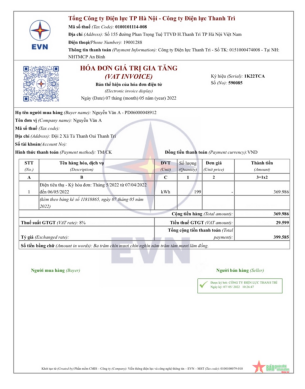

In [6]:


img_path="https://einvoice.vn/FileUpload/ArticleMaterials/images/v%C3%AD%20d%E1%BB%A5%20v%E1%BB%81%20b%E1%BA%A3n%20th%E1%BB%83%20hi%E1%BB%87n%20c%E1%BB%A7a%20h%C3%B3a%20%C4%91%C6%A1n%20%C4%91i%E1%BB%87n%20t%E1%BB%AD.png"
prompt="extract text from picture"
# Tải hình ảnh từ URL
response = requests.get(img_path)
img = Image.open(BytesIO(response.content))

# Hiển thị hình ảnh
plt.imshow(img)
plt.axis('off')  # Ẩn các trục
plt.show()


In [11]:
from IPython.display import Markdown, display

def print_extracted_text(extracted_text):
    formatted_text = '\n'.join([f"* **{item}**" for item in extracted_text.split('\n')])
    display(Markdown(formatted_text))

output = extract_text_with_prompt_from_image(image_url=img_path, prompt=prompt)
print_extracted_text(output)


* **The image contains a Vietnamese invoice with various text elements. The main text elements present in the image are:**
* ****
* *** Company name: EVN**
* *** Invoice number: 0100101114-008**
* *** Date: 07/05/2022**
* *** Buyer's name: Nguyễn Văn A**
* *** Seller's name: CÔNG TY ĐIỆN LỰC THANH TRI**
* *** Payment method: TM/CK**
* *** Total amount: 369,986 VND**
* *** VAT rate: 8%**
* *** Exchanged rate: 29,599 VND**
* *** Payment amount: 399,585 VND**
* ****
* **These text elements provide essential information about the invoice, including the company name, invoice number, date, buyer and seller names, payment method, total amount, VAT rate, exchanged rate, and payment amount.**

#### MessageHistory

In [ ]:
from langchain.vectorstores import FAISS
import sys
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.base import BaseCallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import (
    ConversationalRetrievalChain,
    LLMChain
)
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.prompts.prompt import PromptTemplate
from langchain.memory import MongoDBChatMessageHistory

In [ ]:
connection_string = " your connection string "
message_history = MongoDBChatMessageHistory(
    connection_string=connection_string, session_id="session id that you sent from frontend or client side/ you can use string as well like test1 for testing"
)

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
faiss_index = FAISS.load_local("path to your index folder", embeddings)
question = "your question"
docs = faiss_index.similarity_search(question,4)
context_docs = ""
for doc in docs:
    context_docs = context_docs + doc.page_content + " \n\n "

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
faiss_index = FAISS.load_local("path to your index folder", embeddings)
question = "your question"
docs = faiss_index.similarity_search(question,4)
context_docs = ""
for doc in docs:
    context_docs = context_docs + doc.page_content + " \n\n "

In [ ]:
template = """ your template
Context:\"""
 
{context}
\"""
Question:\"
\"""
 
Helpful Answer:"""
 
qa_prompt= PromptTemplate.from_template(template)

 
streaming_llm = OpenAI(
    streaming=True,
    openai_api_key="your api_key",
    callback_manager=BaseCallbackManager([
        StreamingStdOutCallbackHandler()
    ]),
    verbose=True,
    max_tokens=150,
    temperature=0.2
)

# use the streaming LLM to create a question answering chain
doc_chain = load_qa_chain(
    llm=streaming_llm,
    chain_type="stuff",
    prompt=qa_prompt
)

In [ ]:
chatbot = ConversationalRetrievalChain(
    retriever=faiss_index.as_retriever(),
    combine_docs_chain=doc_chain,
)

response = chatbot(
        {"question": question, "chat_history": message_history.messages}
    )

In [ ]:
message_history.add_user_message(response["question"])
message_history.add_ai_message(response["answer"])